In [1]:
#####################################
### Import the relevant libraries ###
#####################################

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

2024-11-03 19:12:31.511729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730661151.640059    1899 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730661151.673045    1899 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 19:12:31.998291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


***
# **DATA**

In [2]:
##################################
### Download the MNIST dataset ###
##################################

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


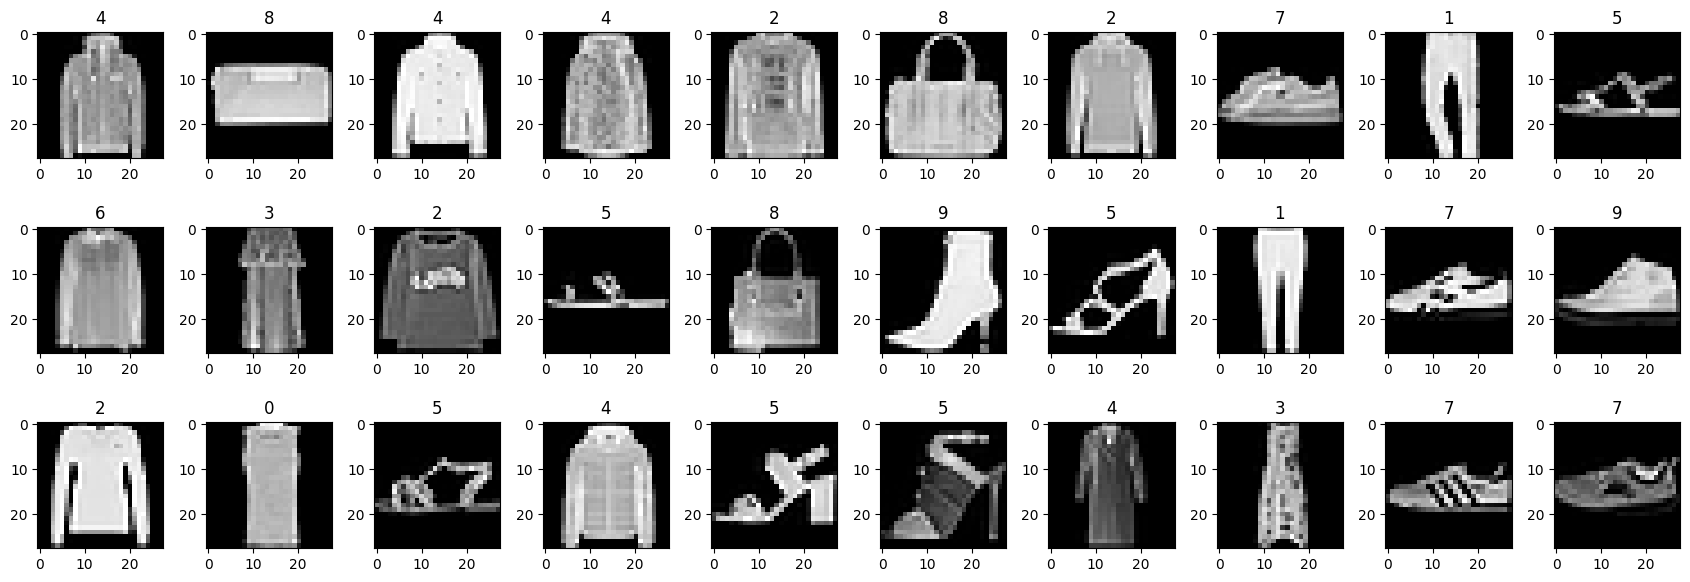

In [3]:
###############################
### Visualise some examples ###
###############################

def display_some_examples(examples, labels, n_examples):
    plt.figure(figsize=(17,6))

    for i in range(n_examples):
        idx = np.random.randint(0, examples.shape[0] - 1)
        img = examples[idx]
        label = labels[idx]

        plt.subplot(3, 10, i + 1)
        plt.title(str(label))
        plt.imshow(img, cmap='gray')

    plt.tight_layout()
    plt.show()

display_some_examples(X_train, y_train, n_examples=30)

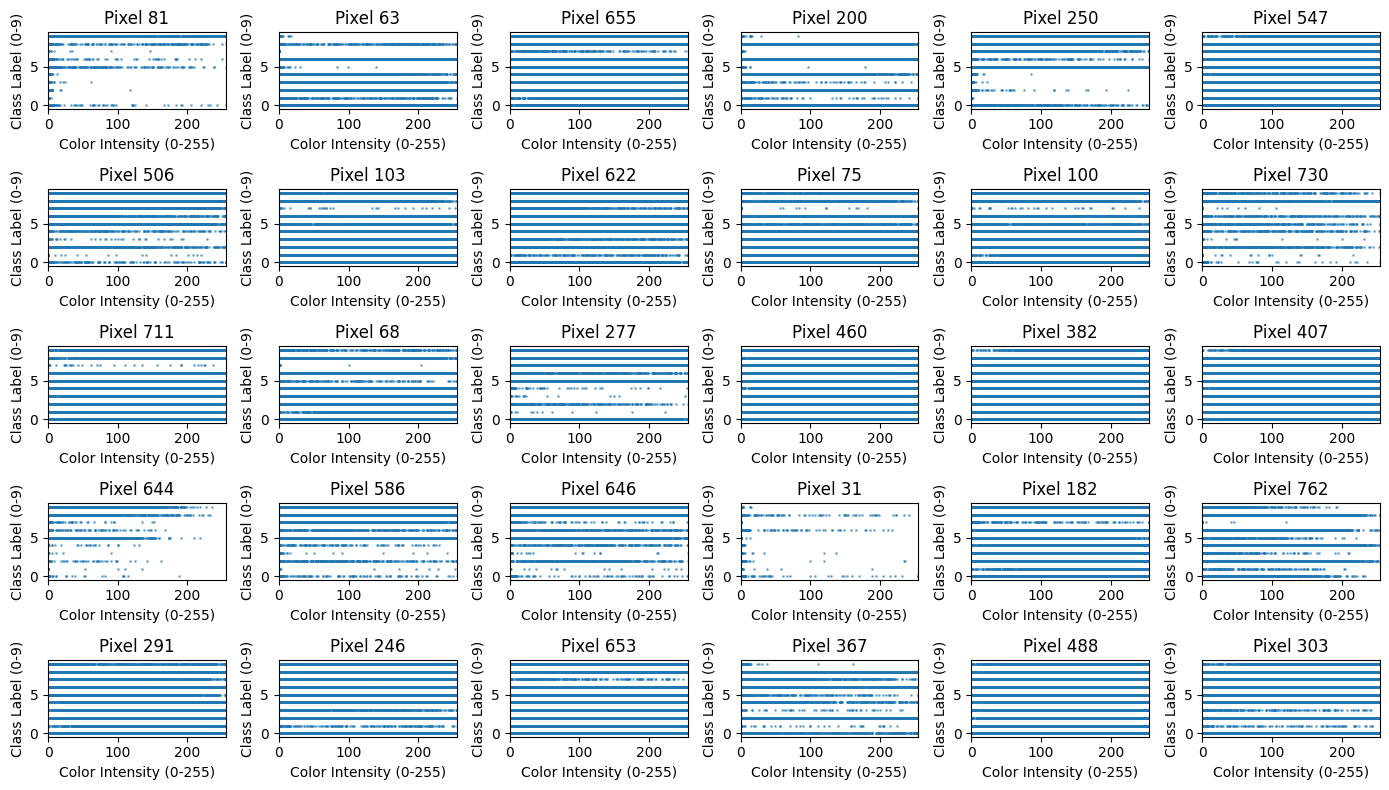

In [4]:
###############################
### Visualise some features ###
###############################

def plot_random_pixels_from_mnist(examples, labels, num_subplots=30):
    # Flatten the examples dataset (assumed to be in shape (num_samples, 28, 28))
    x_train_flattened = examples.reshape(examples.shape[0], 28 * 28)

    # Randomly select 'num_subplots' features (pixels) from 0 to 783
    random_pixel_indices = np.random.choice(28 * 28, num_subplots, replace=False)
    
    plt.figure(figsize=(14, 8))
    
    for i, pixel_idx in enumerate(random_pixel_indices):
        plt.subplot(5, 6, i + 1)  # Create a 5x6 grid of subplots
        
        # Get the color intensities for the selected pixel across all images
        pixel_values = x_train_flattened[:, pixel_idx]
        
        # Plot the pixel values on the x-axis and the class labels (labels) on the y-axis
        plt.scatter(pixel_values, labels, alpha=0.5, s=1)
        
        plt.title(f'Pixel {pixel_idx}')
        plt.xlabel('Color Intensity (0-255)')
        plt.ylabel('Class Label (0-9)')
        plt.xlim([0, 255])  # Color intensity is between 0 and 255
    
    plt.tight_layout()
    plt.show()

# Example usage assuming x_train and y_train are loaded MNIST dataset arrays
plot_random_pixels_from_mnist(X_train, y_train, num_subplots=30)


***
# **BASE TRAINING**

In [5]:
##########################
### Set some variables ###
##########################

input_size = 28 * 28
batch_size = 64
epochs = 6
n_classes = 10
epsilon = 0.3
alpha = 0.1
num_iter = 10


In [6]:
############################
### Pre-process the data ###
############################

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = np.array(X_train).reshape(X_train.shape[0], input_size)
X_test = np.array(X_test).reshape(X_test.shape[0], input_size)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

I0000 00:00:1730661159.286063    1899 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


In [7]:
########################
### Define the model ###
########################

def get_model(input_size):
    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_size,), name='input_features'),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer, name='dense_1'),
            tf.keras.layers.Dense(10, activation='linear', kernel_initializer=initializer, name='output_layer')
        ])
    print(model.summary())
    return model

In [8]:
##########################
### Train a base model ###
##########################

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

model_base = get_model(input_size)
model_base.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_fn])
model_base.fit(train_dataset, epochs=epochs, validation_data=test_dataset,)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/6


I0000 00:00:1730661160.695836    2010 service.cc:148] XLA service 0x7f73cc003320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730661160.696152    2010 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-03 19:12:40.727227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730661160.784503    2010 cuda_dnn.cc:529] Loaded cuDNN version 90300


173/938 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.9865 - sparse_categorical_accuracy: 0.6693

I0000 00:00:1730661161.773502    2010 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


890/938 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.6643 - sparse_categorical_accuracy: 0.7720

2024-11-03 19:12:42.875553: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_108', 4 bytes spill stores, 4 bytes spill loads



938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.7743 - val_loss: 0.4451 - val_sparse_categorical_accuracy: 0.8453
Epoch 2/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3994 - sparse_categorical_accuracy: 0.8584 - val_loss: 0.3922 - val_sparse_categorical_accuracy: 0.8573
Epoch 3/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3525 - sparse_categorical_accuracy: 0.8723 - val_loss: 0.3817 - val_sparse_categorical_accuracy: 0.8647
Epoch 4/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3219 - sparse_categorical_accuracy: 0.8819 - val_loss: 0.3671 - val_sparse_categorical_accuracy: 0.8682
Epoch 5/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3047 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.3709 - val_sparse_categorical_accuracy: 0.8657
Epoch 6/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2901 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.3392 - val_sparse_categorical_accuracy: 0.8772


In [9]:
###############################################################
### Define the precision, recall, F1 and ROC curve function ###
###############################################################

def print_metrics(model, x, y, c):
    # Get predicted probabilities for all classes
    y_pred_prob = model.predict(x)

    # Get predicted class labels (highest probability class)
    y_pred_class = np.argmax(y_pred_prob, axis=1)

    # Calculate precision, recall, and F1-score (using macro average)
    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')

    # Display the macro/micro/weighted average metrics
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

    # Binarize the output (needed for multiclass ROC)
    # This turns the class labels into a one-vs-rest binary format
    y_test_bin = label_binarize(y, classes=np.arange(c))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(c):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(6, 5))
    for i in range(c):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='lower right')
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision (macro): 0.8762
Recall (macro): 0.8772
F1-score (macro): 0.8764


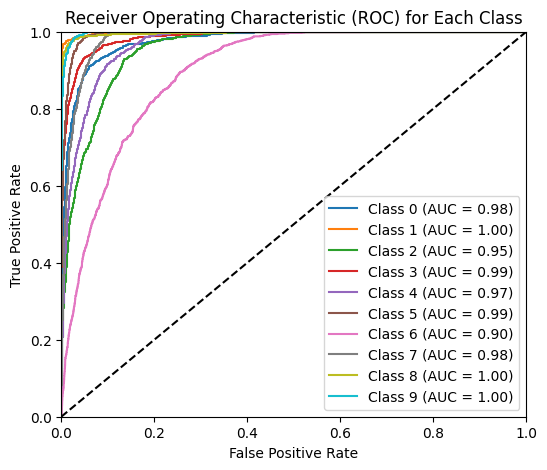

In [10]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print_metrics(model_base, X_test, y_test, n_classes)

In [11]:
######################################
### Define the PGD attack function ###
######################################

def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    """Perform PGD attack on a batch of images.
    
    Args:
        model: Trained Keras model.
        x: Input images (batch).
        y: True labels (batch).
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of PGD iterations.

    Returns:
        Adversarial examples.
    """
    # Make a copy of the input to avoid modifying the original data
    x_adv = tf.identity(x)

    # Iterate PGD for num_iter steps
    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)  # Watch x_adv for gradient computation
            predictions = model(x_adv)  # Forward pass
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)  # Loss w.r.t. true label

        # Compute the gradients of the loss w.r.t. the input
        gradients = tape.gradient(loss, x_adv)
        
        # Perform gradient ascent step in the direction that maximizes the loss
        perturbations = tf.sign(gradients)  # Use the sign of the gradients (FGSM-like step)
        x_adv = x_adv + alpha * perturbations  # Update the adversarial example
        
        # Project the adversarial example to ensure it's within epsilon-ball of the original image
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
        
        # Ensure the adversarial examples are within the valid input range [0, 1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    
    return x_adv

In [12]:
############################################################################
### Define the function to visualize the original and adversarial images ###
############################################################################

def original_vs_adversarial_images(x_og, y_og, x_adv, y_pred):
    plt.figure(figsize=(17, 4))

    # Counter for how many images to display
    display_count = 0

    for i in range(len(x_og)):
        # Check if the class changes after the attack
        if y_og[i] != y_pred[i]:
            # Original images (reshape from (28, 28, 1) to (28, 28))
            original_image = x_og[i].reshape(28, 28)
            
            # Adversarial images (reshape from (28, 28, 1) to (28, 28))
            adversarial_image = x_adv[i].numpy().reshape(28, 28)

            # Plot original images
            plt.subplot(2, 10, display_count + 1)
            plt.imshow(original_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Orig: {y_og[i]}')

            # Plot adversarial images
            plt.subplot(2, 10, display_count + 11)
            plt.imshow(adversarial_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Adv: {y_pred[i]}')

            # Increment the display counter
            display_count += 1
            
            # Stop after displaying 10 images
            if display_count == 10:
                break

    plt.tight_layout()
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
Accuracy on adversarial examples: 0.6479


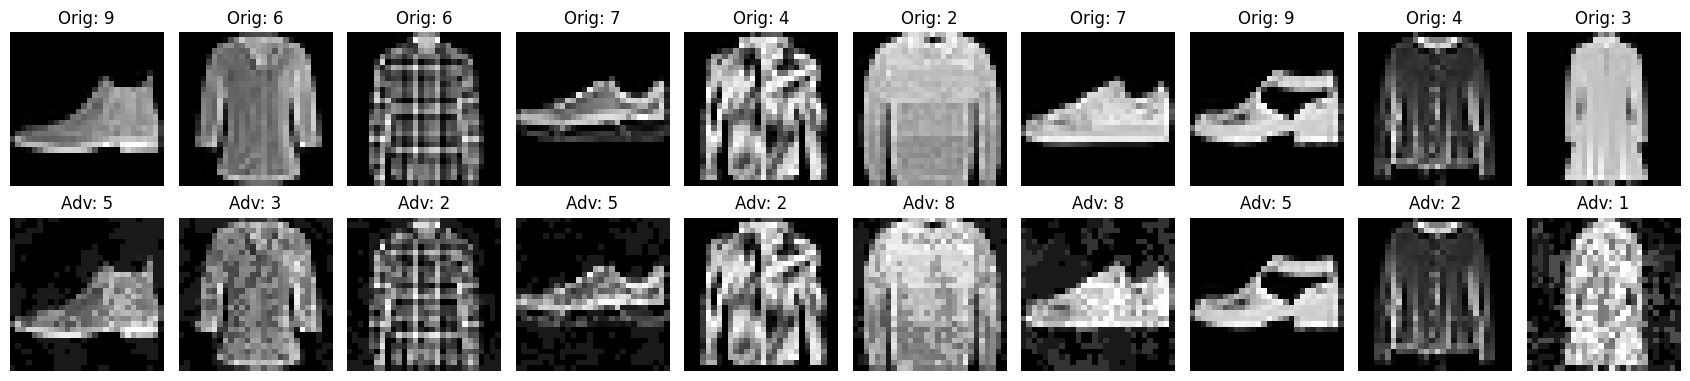

In [13]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample = X_test
y_test_sample = y_test

# Generate adversarial examples
x_test_adv = pgd_attack(model_base, x_test_sample, y_test_sample, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv = np.argmax(model_base.predict(x_test_adv), axis=1)
accuracy_adv = np.mean(y_pred_adv == y_test_sample)

print(f'Accuracy on adversarial examples: {accuracy_adv:.4f}')
original_vs_adversarial_images(x_test_sample, y_test_sample, x_test_adv, y_pred_adv)

***
# **ADVERSARIAL TRAINING**

In [14]:
################################################
### Define the adversarial training function ###
################################################

def adversarial_training(model, train_dataset, optimizer, loss_fn, epsilon, alpha, num_iter, epochs):
    """
    Performs adversarial training with PGD adversarial examples.
    
    Args:
    model: The model to train.
    train_dataset: A TensorFlow dataset for training.
    optimizer: The optimizer for model training.
    loss_fn: Loss function to use.
    epsilon: Maximum perturbation for PGD (epsilon).
    alpha: Step size for PGD.
    num_iter: Number of PGD iterations for generating adversarial examples.
    epochs: Number of training epochs.
    
    Returns:
    model: The trained model.
    """
    for epoch in range(epochs):
        start_time = time.time()  # Record start time for the epoch
        print(f"Epoch {epoch + 1}/{epochs}")

        # Accuracy metric for the epoch
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        
        # Training loop over batches
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Generate adversarial examples using PGD
                x_adv_batch = pgd_attack(model, x_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iter=num_iter)
                
                # Combine original and adversarial examples for training
                combined_x = tf.concat([x_batch, x_adv_batch], axis=0)
                combined_y = tf.concat([y_batch, y_batch], axis=0)
                
                # Forward pass
                logits = model(combined_x, training=True)
                
                # Compute the loss
                loss = loss_fn(combined_y, logits)
            
            # Backpropagation
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update training accuracy metric
            train_acc_metric.update_state(combined_y, logits)

        # End of epoch: calculate and print accuracy and epoch time
        train_acc = train_acc_metric.result().numpy()

        # Evaluate on test dataset (for validation accuracy)
        test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        for x_test_batch, y_test_batch in test_dataset:
            test_logits = model(x_test_batch, training=False)
            test_acc_metric.update_state(y_test_batch, test_logits)
        test_acc = test_acc_metric.result().numpy()

        print(f"Train loss: {loss.numpy():.4f} -|- Train acc: {train_acc:.4f} -|- Test acc: {test_acc:.4f} -|- Time: {(time.time() - start_time):.2f}s")
    
    return model

In [ ]:
##################################
### Train an adversarial model ###
##################################

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_adv = get_model(input_size)
model_adv = adversarial_training(model_adv, train_dataset, optimizer, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter, epochs=epochs)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/6


2024-11-03 19:15:06.863803: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-03 19:15:07.416835: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.5570 -|- Train acc: 0.7773 -|- Test acc: 0.8189 -|- Time: 134.51s
Epoch 2/6


2024-11-03 19:17:21.700367: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.5976 -|- Train acc: 0.8236 -|- Test acc: 0.8537 -|- Time: 134.28s
Epoch 3/6


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision (macro): 0.8666
Recall (macro): 0.8659
F1-score (macro): 0.8638


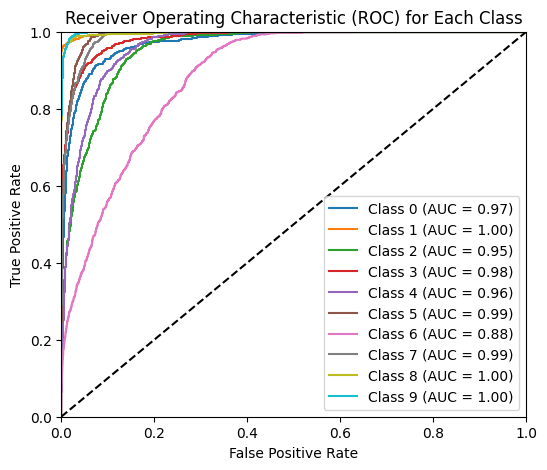

In [ ]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print_metrics(model_adv, X_test, y_test, n_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
Accuracy on adversarial examples: 0.8071


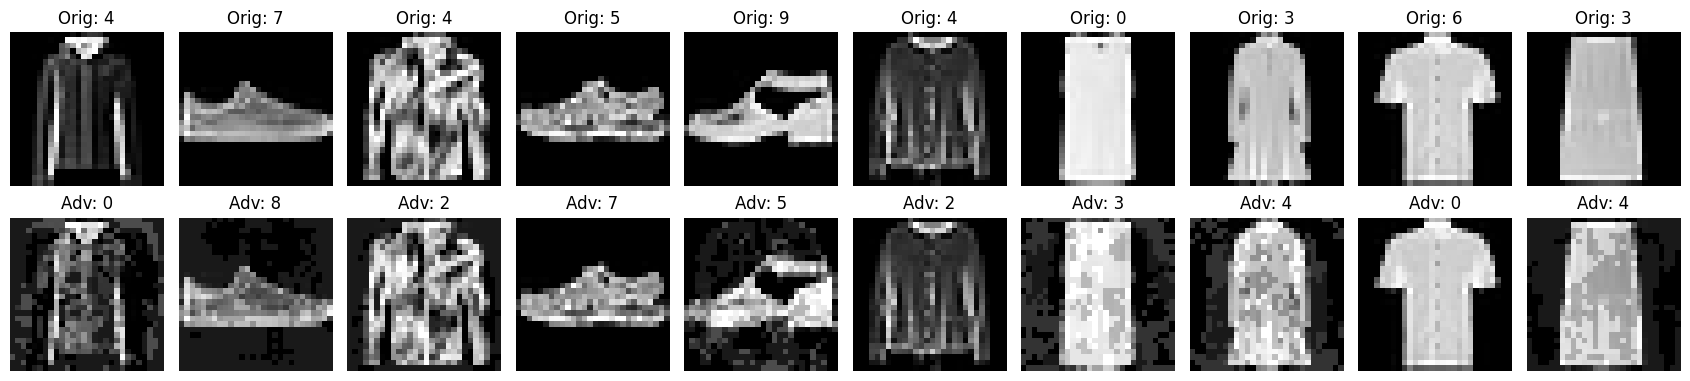

In [ ]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample_ADV = X_test
y_test_sample_ADV = y_test

# Generate adversarial examples
x_test_adv_ADV = pgd_attack(model_adv, x_test_sample_ADV, y_test_sample_ADV, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv_ADV = np.argmax(model_adv.predict(x_test_adv_ADV), axis=1)
accuracy_adv_ADV = np.mean(y_pred_adv_ADV == y_test_sample_ADV)

print(f'Accuracy on adversarial examples: {accuracy_adv_ADV:.4f}')
original_vs_adversarial_images(x_test_sample_ADV, y_test_sample_ADV, x_test_adv_ADV, y_pred_adv_ADV)